**Kd-tree** is a generalization of a binary search tree that stores points in a k-dimensional space. In computer science it is often used for organizing some number of points in a space with k dimensions. Kd-trees are very useful for range and nearest neighbor (NN) searches, it is a very common operation in computer vision, computational geometry, data mining, machine learning, DNA sequencing.

The most efficient way to build a Kd-tree is to use a partitioning method like the Quick Sort uses to place the median point at the root and everything with a smaller one-dimensional value to the left and larger to the right. The procedure is repeated then on both the left and right sub-trees until the last trees to be partitioned are only composed of one element

Slightly edited code from the awesome blogpost at:
https://salzis.wordpress.com/2014/06/28/kd-tree-and-nearest-neighbor-nn-search-2d-case/


In [46]:
from IPython.display import Image
from collections import namedtuple
from operator import itemgetter
from pprint import pformat
import matplotlib.pyplot as plt
import random
import numpy as np

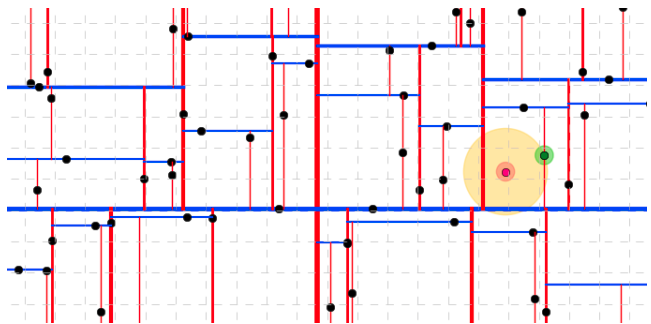

In [47]:
Image(filename='images/' + 'kdtree.png', width=800)

In [48]:
## median-finding sort.
class Node(namedtuple('Node', 'location left_child right_child')):
 
    def __repr__(self):
        return pformat(tuple(self))
 

def kdtree(point_list, depth=0):
    """ build K-D tree
    :param point_list list of input points
    :param depth      current tree's depth
    :return tree node
    """
 
    # assumes all points have the same dimension
    try:
        k = len(point_list[0])
    except IndexError:
        return None
 
    # Select axis based on depth so that axis cycles through
    # all valid values
    axis = depth % k
 
    # Sort point list and choose median as pivot element
    point_list.sort(key=itemgetter(axis))
    median = len(point_list) // 2         # choose median
 
    # Create node and construct subtrees
    return Node(
        location=point_list[median],
        left_child=kdtree(point_list[:median], depth + 1),
        right_child=kdtree(point_list[median + 1:], depth + 1)
    )

In [98]:
# generate an input point-set for building a tree
def generate_point_list(n, min_val, max_val):
    """ generate a list of random points
    :param n        number of points
    :param min_val  minimal value
    :return max_val maximal value
    """
 
    p = []
 
    for i in range(n):
 
        # coordinates as integer values
        p.append((random.randint(min_val,max_val),
                  random.randint(min_val,max_val)))
 
    return p

In [84]:
# line width for visualization of K-D tree
line_width = [4., 3.5, 3., 2.5, 2., 1.5, 1., .5, 0.3]
 
def plot_tree(tree, min_x, max_x, min_y, max_y, prev_node, branch, depth=0):
    """ 
    plot K-D tree
    Args:
        param tree --> input tree to be plotted
        param min_x 
        param max_x
        param min_y
        param max_y
        param prev_node parent's node
        param branch    True if left, False if right
        param depth     tree's depth
        return tree     node
    """
    
    cur_node = tree.location         # current tree's node
    left_branch = tree.left_child    # its left branch
    right_branch = tree.right_child  # its right branch
 
    # set line's width depending on tree's depth
    if depth > len(line_width)-1:
        ln_width = line_width[len(line_width)-1]
    else:
        ln_width = line_width[depth]
 
    k = len(cur_node)
    axis = depth % k
 
    # draw a vertical splitting line
    if axis == 0:
 
        if branch is not None and prev_node is not None:
 
            if branch:
                max_y = prev_node[1]
            else:
                min_y = prev_node[1]
 
        ax.plot([cur_node[0],cur_node[0]], [min_y,max_y], linestyle='-', color='red', 
                 linewidth=ln_width)
 
    # draw a horizontal splitting line
    elif axis == 1:
 
        if branch is not None and prev_node is not None:
 
            if branch:
                max_x = prev_node[0]
            else:
                min_x = prev_node[0]
 
        ax.plot([min_x,max_x], [cur_node[1],cur_node[1]], linestyle='-', color='blue', 
                 linewidth=ln_width)
 
    # draw the current node
    plt.plot(cur_node[0], cur_node[1], 'ko')
 
    # draw left and right branches of the current node
    if left_branch is not None:
        plot_tree(left_branch, min_x, max_x, min_y, max_y, cur_node, True, depth+1)
 
    if right_branch is not None:
        plot_tree(right_branch, min_x, max_x, min_y, max_y, cur_node, False, depth+1)

In [94]:
n = 150       # number of points
min_val = 0   # minimal coordinate value
max_val = 20  # maximal coordinate value
delta=1

point_list = generate_point_list(n=n, min_val=min_val, max_val=max_val)
tree = kdtree(point_list)

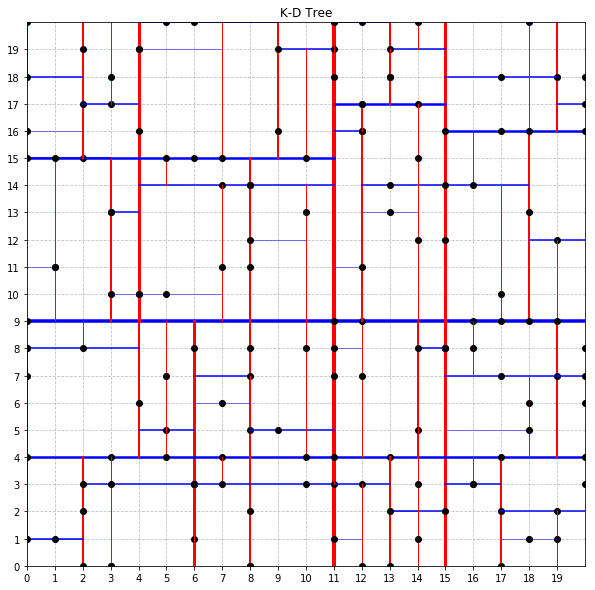

In [97]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))

plot_tree(tree=tree, min_x = min_val-delta, max_x = max_val+delta, 
          min_y = min_val-delta, max_y = max_val+delta, 
          prev_node = None, branch = None, depth =0)
 
_ = ax.set(title = 'K-D Tree', 
       xticks = ([i for i in range(min_val-delta, max_val+delta, 1)]),
       yticks = ([i for i in range(min_val-delta, max_val+delta, 1)]),
       xlim = [min_val-delta, max_val+delta], 
       ylim = [min_val-delta, max_val+delta])
ax.grid(b=True, which='major', color='0.75', linestyle='--')

Red lines show vertical hyperplanes, while blue lines show horizontal hyperplanes. Line thickness corresponds to tree’s depth. We now have a KD-tree and are ready to use NN search. 

In [99]:
nearest_nn = None           # nearest neighbor (NN)
distance_nn = float('inf')  # distance from NN to target
 
def nearest_neighbor_search(tree, target_point, hr, distance, nearest=None, depth=0):
    """ Find the nearest neighbor for the given point (claims O(log(n)) complexity)
    :param tree         K-D tree
    :param target_point given point for the NN search
    :param hr           splitting hyperplane
    :param distance     minimal distance
    :param nearest      nearest point
    :param depth        tree's depth
    """
 
    global nearest_nn
    global distance_nn
 
    if tree is None:
        return
 
    k = len(target_point)
 
    cur_node = tree.location         # current tree's node
    left_branch = tree.left_child    # its left branch
    right_branch = tree.right_child  # its right branch
 
    nearer_kd = further_kd = None
    nearer_hr = further_hr = None
    left_hr = right_hr = None
 
    # Select axis based on depth so that axis cycles through all valid values
    axis = depth % k
 
    # split the hyperplane depending on the axis
    if axis == 0:
        left_hr = [hr[0], (cur_node[0], hr[1][1])]
        right_hr = [(cur_node[0],hr[0][1]), hr[1]]
 
    if axis == 1:
        left_hr = [(hr[0][0], cur_node[1]), hr[1]]
        right_hr = [hr[0], (hr[1][0], cur_node[1])]
 
    # check which hyperplane the target point belongs to
    if target_point[axis] <= cur_node[axis]:
        nearer_kd = left_branch
        further_kd = right_branch
        nearer_hr = left_hr
        further_hr = right_hr
 
    if target_point[axis] > cur_node[axis]:
        nearer_kd = right_branch
        further_kd = left_branch
        nearer_hr = right_hr
        further_hr = left_hr
 
    # check whether the current node is closer
    dist = (cur_node[0] - target_point[0])**2 + (cur_node[1] - target_point[1])**2
 
    if dist < distance:
        nearest = cur_node
        distance = dist
 
    # go deeper in the tree
    nearest_neighbor_search(nearer_kd, target_point, nearer_hr, distance, nearest, depth+1)
 
    # once we reached the leaf node we check whether there are closer points
    # inside the hypersphere
    if distance < distance_nn:
        nearest_nn = nearest
        distance_nn = distance
 
    # a nearer point (px,py) could only be in further_kd (further_hr) -> explore it
    px = compute_closest_coordinate(target_point[0], further_hr[0][0], further_hr[1][0])
    py = compute_closest_coordinate(target_point[1], further_hr[1][1], further_hr[0][1])
 
    # check whether it is closer than the current nearest neighbor => whether a hypersphere crosses the hyperplane
    dist = (px - target_point[0])**2 + (py - target_point[1])**2
 
    # explore the further kd-tree / hyperplane if necessary
    if dist < distance_nn:
        nearest_neighbor_search(further_kd, target_point, further_hr, distance, nearest, depth+1)


The closest coordinate of the nighboring hyperplane is computed as:



In [100]:
def compute_closest_coordinate(value, range_min, range_max):
    """ Compute the closest coordinate for the neighboring hyperplane
    :param value     coordinate value (x or y) of the target point
    :param range_min minimal coordinate (x or y) of the neighboring hyperplane
    :param range_max maximal coordinate (x or y) of the neighboring hyperplane
    :return x or y coordinate
    """
 
    v = None
 
    if range_min < value < range_max:
        v = value
 
    elif value <= range_min:
        v = range_min
 
    elif value >= range_max:
        v = range_max
 
    return v

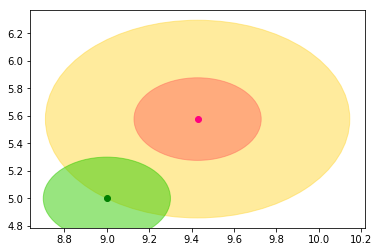

In [102]:
import math
 
# generate a random point on the grid
point = (np.random.normal(random.randint(min_val,max_val), scale=0.5), np.random.normal(random.randint(min_val,max_val), scale=0.5))
 
delta = 2  # extension of the drawing range
 
hr = [(min_val-delta, max_val+delta), (max_val+delta, min_val-delta)]  # initial splitting plane
max_dist = float('inf')
 
# find the nearest neighbor
nearest_neighbor_search(tree, point, hr, max_dist)
 
# draw the given point
plt.plot(point[0], point[1], marker='o', color='#ff007f')
circle = plt.Circle((point[0], point[1]), 0.3, facecolor='#ff007f', edgecolor='#ff007f', alpha=0.5)
plt.gca().add_patch(circle)
 
# draw the hypersphere around the target point
circle = plt.Circle((point[0], point[1]), math.sqrt(distance_nn), facecolor='#ffd83d', edgecolor='#ffd83d', alpha=0.5)
plt.gca().add_patch(circle)
 
# draw the found nearest neighbor
plt.plot(nearest_nn[0], nearest_nn[1], 'go')
circle = plt.Circle((nearest_nn[0], nearest_nn[1]), 0.3, facecolor='#33cc00', edgecolor='#33cc00', alpha=0.5)
plt.gca().add_patch(circle)